## McDermSem1 Data Analysis

Hi, welcome. This is a Jupyter Notebook, which is a kind of hybrid document- and running script. For the long list of results, please scroll to the bottom. If you're interested in how the figures were calculated, you can check the code (for 'features'). More likely than not, you'll want to just scroll past this to the last few cells.

In [3]:
from glob import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import warnings

### Preliminaries

The following cell collects and parses data. For correlations and visualizations, see below.

In [4]:
DATA_PATH = './data'
data_ext = '*.csv'

search_path = os.path.join(DATA_PATH, data_ext)
filenames = glob(search_path)
assert filenames, 'No files found matching pattern {}.'.format(
    os.path.abspath(search_path)
)

scales = ['Busy', 'Fused', 'Kaleidoscopic']
method = 'spearman'

orig, stat, spec = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for file in filenames:
    df = pd.read_csv(file)

    # Parse data with a warning message in first row.
    if df.columns.size == 1:
        warnings.warn(
            'File {} is flagged. Skipping first row...'.format(
                os.path.basename(file)
            )
        )
        df = pd.read_csv(file, skiprows=1)

    orig = orig.append(df[df['type'] == 'O'])
    stat = stat.append(df[df['type'] == '32R'])
    spec = spec.append(df[df['type'] == 'S'])

orig = orig.reset_index(drop=True)
stat = stat.reset_index(drop=True)
spec = spec.reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: File 0028.20210208.5fe798172fd45c14e596930d.csv is flagged. Skipping first row...


### Helpers

The following are functions for quick data analysis.

In [11]:
def ave_corr(df, method, r2=False):
    """Correlations from averaging ratings over each stimulus."""
    tmp = df.groupby(df['stimNo']).mean()
    
    out_ = tmp[scales].corr(method=method)
    
    if r2:
        out_ = out_ ** 2
    
    return out_

def ave_corrwith(df1, df2, method, r2=False):
    """Cross-scale correlations from averaging ratings over each stimulus."""
    tmp1 = df1.groupby(df1['stimNo']).mean()
    tmp1 = tmp1.reset_index()[scales]
    
    tmp2 = df2.groupby(df2['stimNo']).mean()
    tmp2 = tmp2.reset_index()[scales]
    
    out_ = tmp1.corrwith(tmp2, method=method)
    
    if r2:
        out_ = out_ ** 2
    
    return out_


def subject_corr(df1, method, r2=False):
    """Internal subjects scale correlations. Correlations are averaged across subjects."""
    tmp = df[scales].groupby(df['participant']).corr(method=method)
    
    if r2:
        tmp = tmp ** 2
    
    return tmp.mean(level=1)

def subject_corrwith(df1, df2, method, r2=False):
    """Internal subjects cross-scale correlations. Correlations are averaged across subjects."""
    tmp = pd.DataFrame()
    
    grouped1 = df1[scales].groupby(df1['participant'])
    grouped2 = df2[scales].groupby(df2['participant'])

    for (participant_no, ratings1), (_, ratings2) in zip(grouped1, grouped2):
        tmp[participant_no] = ratings1.corrwith(ratings2, method=method)
        
    if r2:
        tmp = tmp ** 2

    return tmp.mean(axis=1)

def macro(method, r2):
    plt.title('Orig across scales (within subj.)')
    sns.heatmap(subject_corr(orig, method, r2=r2), annot=True)
    plt.show()
    
    plt.title('Orig across scales (across subj.)')
    sns.heatmap(ave_corr(orig, method, r2=r2), annot=True)
    plt.show()

    plt.title('Stat across scales (within subj.)')
    sns.heatmap(subject_corr(stat, method, r2=r2), annot=True)
    plt.show()

    plt.title('Stat across scales (across subj.)')
    sns.heatmap(ave_corr(stat, method, r2=r2), annot=True)
    plt.show()

    plt.title('Spec across scales (within subj.)')
    sns.heatmap(subject_corr(spec, method, r2=r2), annot=True)
    plt.show()
    
    plt.title('Spec across scales (across subj.)')
    sns.heatmap(ave_corr(spec, method, r2=r2), annot=True)
    plt.show()
    
    print('Orig corr. stat (within subj.)')
    display(subject_corrwith(orig, stat, method, r2=r2))
    print('Orig corr. stat (across subj.)')
    display(ave_corrwith(orig, stat, method, r2=r2))

    print('Orig corr. spec (within subj.)')
    display(subject_corrwith(orig, spec, method, r2=r2))
    print('Orig corr. spec (across subj.)')
    display(ave_corrwith(orig, spec, method, r2=r2))

    print('Stat corr. spec (within subj.)')
    display(subject_corrwith(stat, spec, method, r2=r2))
    print('Stat corr. spec (across subj.)')
    display(ave_corrwith(stat, spec, method, r2=r2))

### Results

Resulting figures and data visualization. Data accepts method (`'spearman'` or `'pearson'`) and a flag for r^2 calculations (`r2=False` means just calculate the r value... I'm sure you can figure out what `r2=True` does).

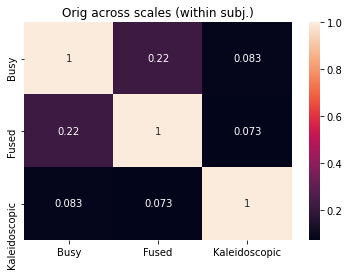

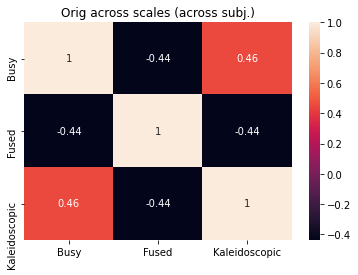

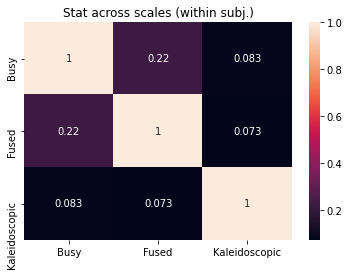

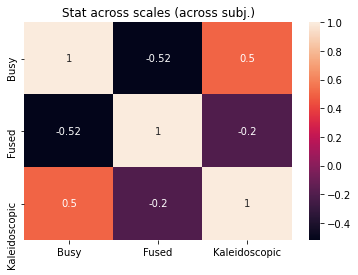

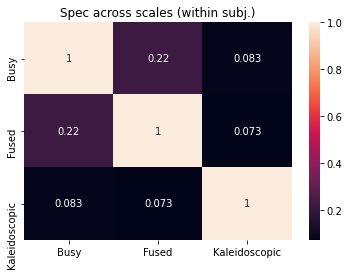

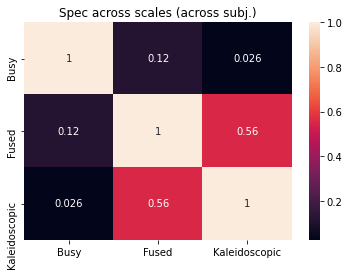

Orig corr. stat (within subj.)


Busy             0.479160
Fused            0.416214
Kaleidoscopic    0.431753
dtype: float64

Orig corr. stat (across subj.)


Busy             0.854850
Fused            0.279197
Kaleidoscopic    0.726341
dtype: float64

Orig corr. spec (within subj.)


Busy             0.321466
Fused            0.170662
Kaleidoscopic    0.233556
dtype: float64

Orig corr. spec (across subj.)


Busy             0.765680
Fused           -0.182910
Kaleidoscopic    0.215894
dtype: float64

Stat corr. spec (within subj.)


Busy             0.388318
Fused            0.238789
Kaleidoscopic    0.289691
dtype: float64

Stat corr. spec (across subj.)


Busy             0.846899
Fused            0.192446
Kaleidoscopic    0.553487
dtype: float64

In [12]:
# All results displayed for the Pearson correlation r values.

macro('pearson', r2=False)

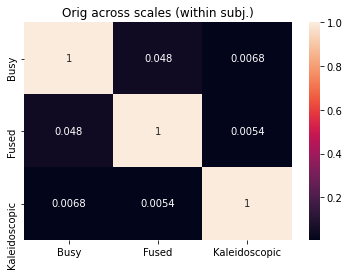

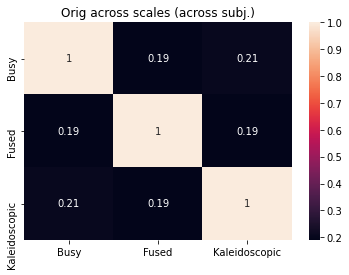

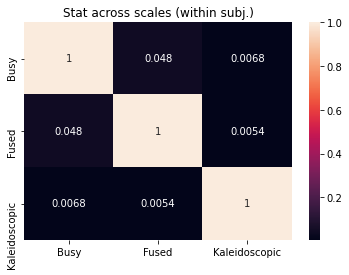

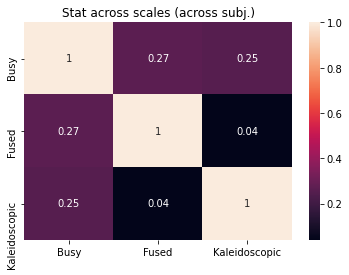

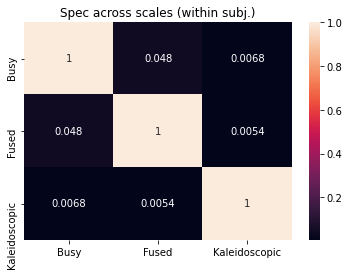

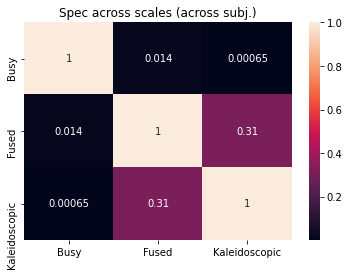

Orig corr. stat (within subj.)


Busy             0.294051
Fused            0.245876
Kaleidoscopic    0.232536
dtype: float64

Orig corr. stat (across subj.)


Busy             0.730768
Fused            0.077951
Kaleidoscopic    0.527572
dtype: float64

Orig corr. spec (within subj.)


Busy             0.178145
Fused            0.103880
Kaleidoscopic    0.090529
dtype: float64

Orig corr. spec (across subj.)


Busy             0.586266
Fused            0.033456
Kaleidoscopic    0.046610
dtype: float64

Stat corr. spec (within subj.)


Busy             0.229565
Fused            0.143094
Kaleidoscopic    0.117246
dtype: float64

Stat corr. spec (across subj.)


Busy             0.717237
Fused            0.037036
Kaleidoscopic    0.306348
dtype: float64

In [13]:
# All results displayed for the Pearson correlation r^2 values.

macro('pearson', r2=True)

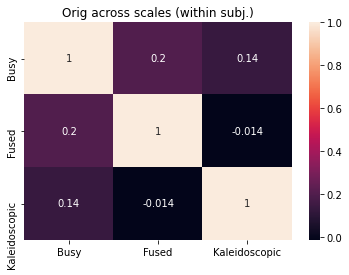

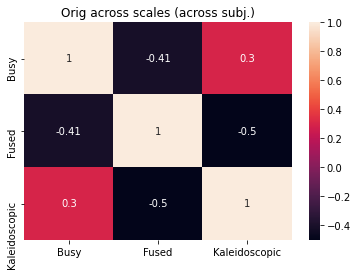

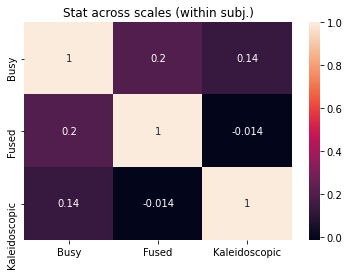

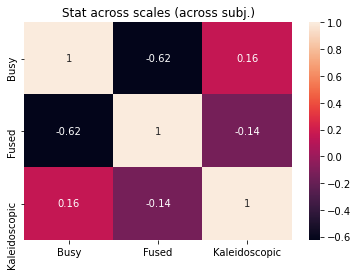

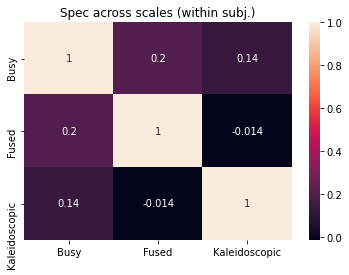

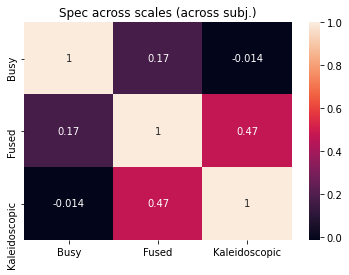

Orig corr. stat (within subj.)


Busy             0.443878
Fused            0.393250
Kaleidoscopic    0.384015
dtype: float64

Orig corr. stat (across subj.)


Busy             0.923308
Fused            0.377444
Kaleidoscopic    0.600000
dtype: float64

Orig corr. spec (within subj.)


Busy             0.298361
Fused            0.167075
Kaleidoscopic    0.214663
dtype: float64

Orig corr. spec (across subj.)


Busy             0.772932
Fused           -0.144361
Kaleidoscopic    0.024060
dtype: float64

Stat corr. spec (within subj.)


Busy             0.347188
Fused            0.228396
Kaleidoscopic    0.267528
dtype: float64

Stat corr. spec (across subj.)


Busy             0.846617
Fused            0.042105
Kaleidoscopic    0.484211
dtype: float64

In [14]:
# All results displayed for the Spearman correlation r values.

macro('spearman', r2=False)

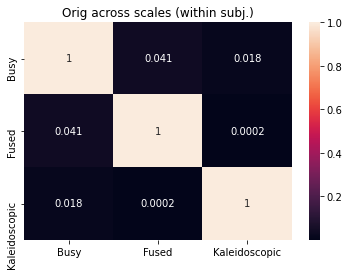

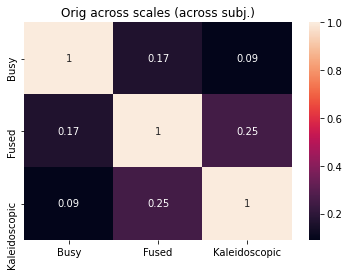

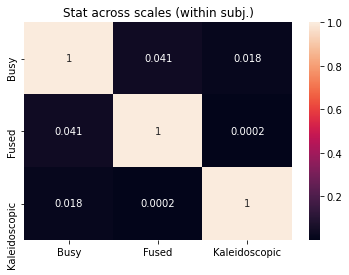

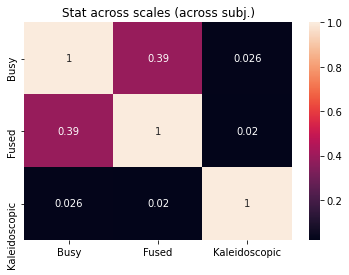

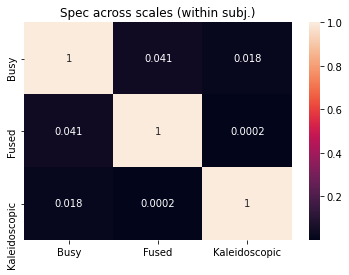

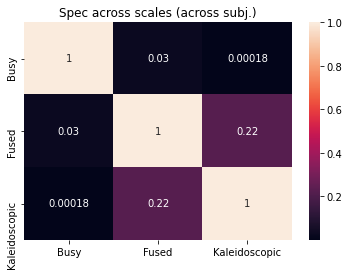

Orig corr. stat (within subj.)


Busy             0.277196
Fused            0.221223
Kaleidoscopic    0.189485
dtype: float64

Orig corr. stat (across subj.)


Busy             0.852498
Fused            0.142464
Kaleidoscopic    0.360000
dtype: float64

Orig corr. spec (within subj.)


Busy             0.142114
Fused            0.109243
Kaleidoscopic    0.085892
dtype: float64

Orig corr. spec (across subj.)


Busy             0.597424
Fused            0.020840
Kaleidoscopic    0.000579
dtype: float64

Stat corr. spec (within subj.)


Busy             0.191270
Fused            0.143964
Kaleidoscopic    0.114661
dtype: float64

Stat corr. spec (across subj.)


Busy             0.716760
Fused            0.001773
Kaleidoscopic    0.234460
dtype: float64

In [15]:
# All results displayed for the Spearman correlation r^2 values.

macro('spearman', r2=True)